# Question Classification Notebook Using Transformers approach
@ author: Raby3


## Import libraries

In [ ]:
!pip install gdown
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import gdown
from contractions import fix

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Data Loading and Parsing

In [ ]:
%%capture
#Loading Videos and aligned transcriptions (Annotaions)
url = 'https://drive.google.com/drive/folders/1w_x5uJz6fVlVciSijUD7u_4xMNWFNKS-?usp=drive_link'
gdown.download_folder(url, quiet=True)

In [ ]:
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            # Split label and question
            label, question = line.strip().split(' ', 1)
            data.append({"question": question, "label": label})
    return pd.DataFrame(data)

train_set = load_data("/content/data/train_set5.txt")
test_set = load_data("/content/data/test_set.txt")

print(train_set.head())


                                            question        label
0  How did serfdom develop in and then leave Russ...  DESC:manner
1   What films featured the character Popeye Doyle ?  ENTY:cremat
2  How can I find a list of celebrities ' real na...  DESC:manner
3  What fowl grabs the spotlight after the Chines...  ENTY:animal
4                    What is the full form of .com ?     ABBR:exp


## Text Preprocessing

1. Lowercased text.
2. Removed special characters and numbers using regex.
3. Tokenized text into words using nltk.
4. Removed stopwords
5. Applied lemmatization for text normalization.

In [ ]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
wh_words = {"who", "what", "where", "when", "why", "how", "is", "are", "does", "do", "did","was"}
custom_stop_words = stop_words - wh_words

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = fix(text)
    words = word_tokenize(text)
    words = [word for word in words if word not in custom_stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

train_set_processed['processed_question'] = train_set['question'].apply(preprocess_text)
test_set_processed['processed_question'] = test_set['question'].apply(preprocess_text)


In [ ]:
train_set_processed['processed_question'].head(20)

,processed_question
0,how did serfdom develop leave russia
1,what film featured character popeye doyle
2,how find list celebrity real name
3,what fowl grab spotlight chinese year monkey
4,what is full form com
5,what contemptible scoundrel stole cork lunch
6,what team did baseball st louis brown become
7,what is oldest profession
8,what are liver enzyme
9,name scarfaced bounty hunter old west


##Bert for Question Classification##
Question and Answer Classification with Deep Contextualized Transformer
Attention is all you need
Attention-Based Transformer-BiGRU for
Question Classification


In [ ]:
import re
import tqdm
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.optim as optim

In [ ]:
#Turning the Data Tabular
url = "https://drive.google.com/file/d/1_0zmdY5EBX3m83Xo1F6uYYFsUp5RHjRW/view?usp=drive_link"
gdown.download_folder(url, quiet=True)

Failed to retrieve folder contents


In [ ]:
#Tokenizer for Bert
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Dataset
class QuestionDataset(Dataset):
    def __init__(self, questions, labels, max_len=64):
        super(QuestionDataset, self).__init__()
        self.questions = questions
        self.labels = labels
        self.max_len = max_len # Max length for the inputs
    def __getitem__(self, item):
        question = self.questions[item]
        label = self.labels[item]

        # Turn Questions in Tokens
        encoded_dict = tokenizer.encode_plus(
            question,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids'].squeeze()
        attention_mask = encoded_dict['attention_mask'].squeeze()
        return input_ids, attention_mask, torch.tensor(label)

    def __len__(self):
        return len(self.questions)

In [ ]:
#Modeling
class BertQuestionClassification(nn.Module):
    def __init__(self, n_classes, pretrained_name='bert-base-uncased'):
        super(BertQuestionClassification, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_name) #Loading pretrained
        self.dropout = nn.Dropout(0.1)  #Adding a drop out layer
        self.classification = nn.Linear(self.bert.config.hidden_size, n_classes) #Fully connected Dense layer to map out put to classes

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids, attention_mask) #Binary mask indicating which tokens are padding (0) and which are real tokens (1)
        out = out.last_hidden_state[:, 0, :] #Extracts the embedding for the [CLS] token : ummary representation
        out = self.dropout(out) # regularize for the CLS
        out = self.classification(out) # pass CLS through dense layer --> logits for each class

        return out #(Batch size , n_classes)


In [ ]:
#Building methods
def category_to_index(csv_path='/content/Question_Classification_Dataset.csv'):
    df = pd.read_csv(csv_path)
    label = df['Category0']
    category = sorted(set(label.values))
    return {word: index for index, word in enumerate(category)} # Dectionnary mapping Categories to numbers
def get_data(csv_path='/content/Question_Classification_Dataset.csv'):
    df = pd.read_csv(csv_path)
    questions = list(df['Questions'])
    category = category_to_index(csv_path=csv_path)
    labels = [category[i] for i in df['Category0'].values]
    return questions, labels # List of questions and their corresponding integer labels

Using device: cuda
Epoch 1/20


100%|██████████| 58/58 [00:20<00:00,  2.80it/s]


Train Loss: 0.9745 | Validation Loss: 0.3682 | Validation F1: 0.8037
Epoch 2/20


100%|██████████| 58/58 [00:21<00:00,  2.73it/s]


Train Loss: 0.2561 | Validation Loss: 0.2549 | Validation F1: 0.8774
Epoch 3/20


100%|██████████| 58/58 [00:21<00:00,  2.66it/s]


Train Loss: 0.1100 | Validation Loss: 0.2492 | Validation F1: 0.9084
Epoch 4/20


100%|██████████| 58/58 [00:22<00:00,  2.62it/s]


Train Loss: 0.0647 | Validation Loss: 0.2588 | Validation F1: 0.9070
Epoch 5/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0364 | Validation Loss: 0.2757 | Validation F1: 0.9068
Epoch 6/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0220 | Validation Loss: 0.2889 | Validation F1: 0.9104
Epoch 7/20


100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Train Loss: 0.0118 | Validation Loss: 0.2726 | Validation F1: 0.9085
Epoch 8/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0149 | Validation Loss: 0.3264 | Validation F1: 0.9224
Epoch 9/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0057 | Validation Loss: 0.2877 | Validation F1: 0.9264
Epoch 10/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0027 | Validation Loss: 0.3063 | Validation F1: 0.9255
Epoch 11/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0023 | Validation Loss: 0.3170 | Validation F1: 0.9247
Epoch 12/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0018 | Validation Loss: 0.3259 | Validation F1: 0.9178
Epoch 13/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0018 | Validation Loss: 0.3290 | Validation F1: 0.9248
Epoch 14/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0014 | Validation Loss: 0.3314 | Validation F1: 0.9266
Epoch 15/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0012 | Validation Loss: 0.3360 | Validation F1: 0.9266
Epoch 16/20


100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Train Loss: 0.0011 | Validation Loss: 0.3386 | Validation F1: 0.9265
Epoch 17/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0010 | Validation Loss: 0.3448 | Validation F1: 0.9268
Epoch 18/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0009 | Validation Loss: 0.3596 | Validation F1: 0.9263
Epoch 19/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0008 | Validation Loss: 0.3620 | Validation F1: 0.9264
Epoch 20/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0009 | Validation Loss: 0.3491 | Validation F1: 0.9163


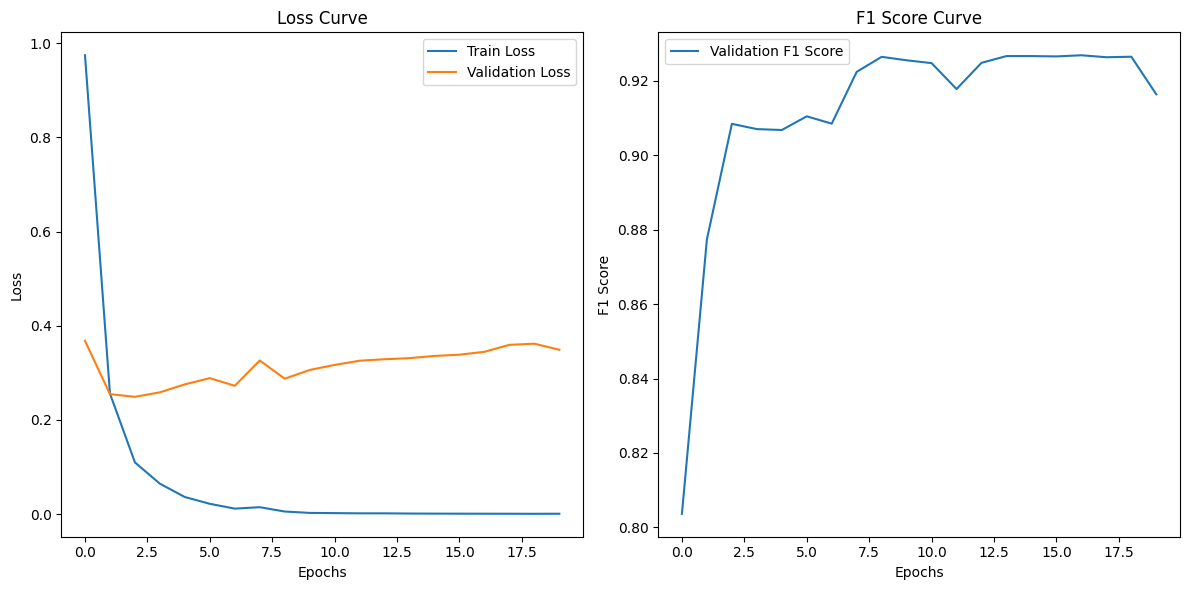

In [ ]:
def train_model():
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data
    questions, labels = get_data()

    # Split data
    X_trainval, X_test, y_trainval, y_test = train_test_split(questions, labels, test_size=0.3, random_state=2021)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.4, random_state=2021)

    # Create datasets and dataloaders
    BATCH_SIZE = 40
    train_dataset = QuestionDataset(X_train, y_train)
    val_dataset = QuestionDataset(X_val, y_val)
    test_dataset = QuestionDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=len(X_test))

    # Initialize model and move it to the device
    model = BertQuestionClassification(n_classes=6)
    model = model.to(device)  # Move model to GPU

    # Define optimizer and loss function
    optimizer = Adam(model.parameters(), lr=2e-5)
    loss_fn = CrossEntropyLoss()

    # Training loop
    N_EPOCHS = 20
    MODEL_SAVE_PATH = '/content/model.pth'
    train_losses = []
    val_losses = []
    val_f1scores = []

    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch + 1}/{N_EPOCHS}")

        # Training
        model.train()
        train_batch_losses = []
        for input_ids, attention_mask, y_train_batch in tqdm.tqdm(train_dataloader):
            # Move data to GPU
            input_ids, attention_mask, y_train_batch = input_ids.to(device), attention_mask.to(device), y_train_batch.to(device)

            y_train_pred = model(input_ids, attention_mask)
            loss = loss_fn(y_train_pred, y_train_batch)
            train_batch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_batch_losses = []
        val_batch_f1scores = []
        with torch.no_grad(): #No gradient calculation
            for input_ids, attention_mask, y_val_batch in val_dataloader:
                # Move data to GPU
                input_ids, attention_mask, y_val_batch = input_ids.to(device), attention_mask.to(device), y_val_batch.to(device)

                y_val_pred = model(input_ids, attention_mask)
                loss = loss_fn(y_val_pred, y_val_batch)
                val_batch_losses.append(loss.item())

                # Compute F1 score
                predictions = torch.argmax(torch.nn.functional.softmax(y_val_pred, dim=-1), dim=-1)
                val_batch_f1scores.append(
                    f1_score(predictions.cpu(), y_val_batch.cpu(), average='macro')
                )

        # Metrics
        train_losses.append(sum(train_batch_losses) / len(train_batch_losses))
        val_losses.append(sum(val_batch_losses) / len(val_batch_losses))
        val_f1scores.append(sum(val_batch_f1scores) / len(val_batch_f1scores))

        # Save model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

        print(f"Train Loss: {train_losses[-1]:.4f} | Validation Loss: {val_losses[-1]:.4f} | Validation F1: {val_f1scores[-1]:.4f}")
    # Plot training curves
    plot_training_curves(train_losses, val_losses, val_f1scores)
# Entry point
if __name__ == '__main__':
    train_model()


#MultiLabel#

In [ ]:
def category_to_index(csv_path='/content/Question_Classification_Dataset.csv'):
    df = pd.read_csv(csv_path)
    # Combine Category0 and Category2 to create unique pairs
    combined_categories = df.apply(lambda row: f"{row['Category0']}:{row['Category2']}", axis=1)
    unique_pairs = sorted(set(combined_categories))
    return {pair: index for index, pair in enumerate(unique_pairs)}

def get_data(csv_path='/content/Question_Classification_Dataset.csv'):
    df = pd.read_csv(csv_path)
    questions = list(df['Questions'])
    category_map = category_to_index(csv_path=csv_path)

    # Encode labels as binary vectors
    labels = [[0] * len(category_map) for _ in range(len(df))]
    for idx, row in df.iterrows():
        pair = f"{row['Category0']}:{row['Category2']}"
        labels[idx][category_map[pair]] = 1

    return questions, labels


In [ ]:
def plot_training_curves(train_losses, val_losses, val_f1scores):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(range(len(val_f1scores)), val_f1scores, label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()


Using device: cuda
Epoch 1/20


100%|██████████| 58/58 [00:22<00:00,  2.57it/s]


Train Loss: 0.3185 | Validation Loss: 0.1966 | Validation F1: 0.6149
Epoch 2/20


100%|██████████| 58/58 [00:22<00:00,  2.57it/s]


Train Loss: 0.1832 | Validation Loss: 0.1543 | Validation F1: 0.6149
Epoch 3/20


100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Train Loss: 0.1468 | Validation Loss: 0.1284 | Validation F1: 0.6149
Epoch 4/20


100%|██████████| 58/58 [00:22<00:00,  2.58it/s]


Train Loss: 0.1233 | Validation Loss: 0.1094 | Validation F1: 0.6290
Epoch 5/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.1053 | Validation Loss: 0.0944 | Validation F1: 0.6567
Epoch 6/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0909 | Validation Loss: 0.0827 | Validation F1: 0.6923
Epoch 7/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0789 | Validation Loss: 0.0729 | Validation F1: 0.7063
Epoch 8/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0690 | Validation Loss: 0.0643 | Validation F1: 0.7469
Epoch 9/20


100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Train Loss: 0.0602 | Validation Loss: 0.0576 | Validation F1: 0.7733
Epoch 10/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0526 | Validation Loss: 0.0517 | Validation F1: 0.7878
Epoch 11/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0461 | Validation Loss: 0.0466 | Validation F1: 0.8104
Epoch 12/20


100%|██████████| 58/58 [00:22<00:00,  2.58it/s]


Train Loss: 0.0406 | Validation Loss: 0.0429 | Validation F1: 0.8288
Epoch 13/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0360 | Validation Loss: 0.0394 | Validation F1: 0.8378
Epoch 14/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0318 | Validation Loss: 0.0367 | Validation F1: 0.8584
Epoch 15/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0284 | Validation Loss: 0.0344 | Validation F1: 0.8693
Epoch 16/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0254 | Validation Loss: 0.0328 | Validation F1: 0.8801
Epoch 17/20


100%|██████████| 58/58 [00:22<00:00,  2.60it/s]


Train Loss: 0.0230 | Validation Loss: 0.0308 | Validation F1: 0.8834
Epoch 18/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0208 | Validation Loss: 0.0294 | Validation F1: 0.8899
Epoch 19/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0191 | Validation Loss: 0.0280 | Validation F1: 0.8920
Epoch 20/20


100%|██████████| 58/58 [00:22<00:00,  2.59it/s]


Train Loss: 0.0173 | Validation Loss: 0.0274 | Validation F1: 0.8976


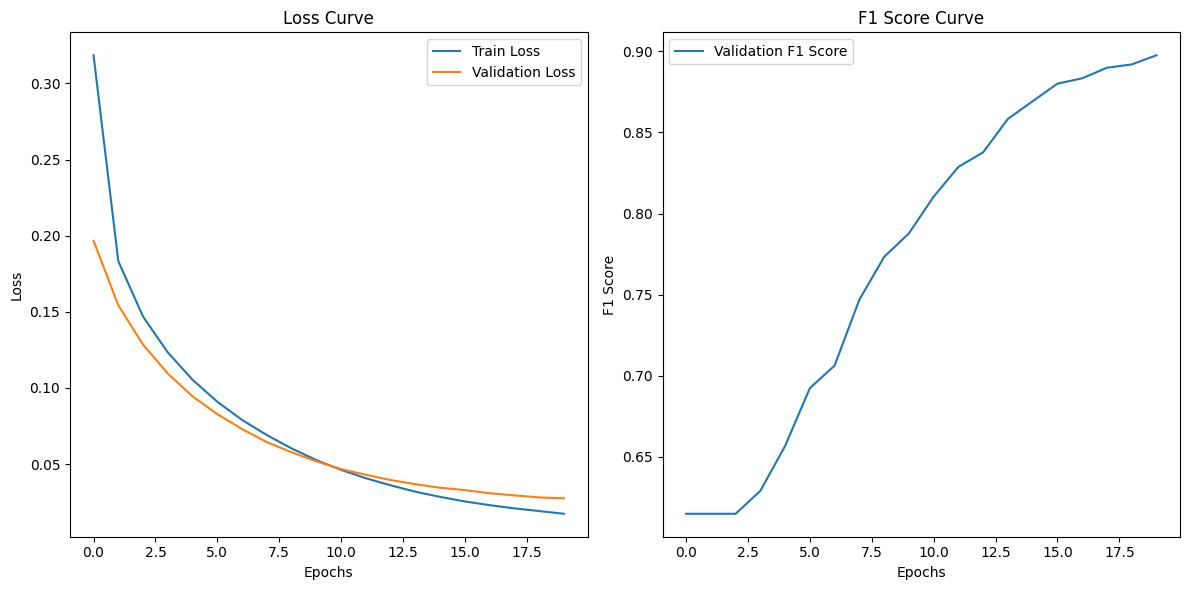

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, hamming_loss
def train_model():
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data
    questions, labels = get_data()

    # Split data
    X_trainval, X_test, y_trainval, y_test = train_test_split(questions, labels, test_size=0.3, random_state=2021)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.4, random_state=2021)

    # Create datasets and dataloaders
    BATCH_SIZE = 40
    train_dataset = QuestionDataset(X_train, y_train)
    val_dataset = QuestionDataset(X_val, y_val)
    test_dataset = QuestionDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=len(X_test))

    # Initialize model and move it to the device
    n_classes = len(labels[0])  # Number of unique label combinations
    model = BertQuestionClassification(n_classes=n_classes)
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    loss_fn = nn.BCEWithLogitsLoss() #For multilabel

    # Training loop
    N_EPOCHS = 20
    MODEL_SAVE_PATH = '/content/model_Multilabel.pth'
    train_losses = []
    val_losses = []
    val_f1scores = []

    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch + 1}/{N_EPOCHS}")

        # Training
        model.train()
        train_batch_losses = []
        for input_ids, attention_mask, y_train_batch in tqdm.tqdm(train_dataloader):
            # Move data to GPU
            input_ids, attention_mask, y_train_batch = (
                input_ids.to(device),
                attention_mask.to(device),
                y_train_batch.float().to(device),
            )

            y_train_pred = model(input_ids, attention_mask)
            loss = loss_fn(y_train_pred, y_train_batch)
            train_batch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_batch_losses = []
        val_batch_f1scores = []
        with torch.no_grad():  # No gradient calculation
            for input_ids, attention_mask, y_val_batch in val_dataloader:
                # Move data to GPU
                input_ids, attention_mask, y_val_batch = (
                    input_ids.to(device),
                    attention_mask.to(device),
                    y_val_batch.float().to(device),
                )

                y_val_pred = model(input_ids, attention_mask)
                loss = loss_fn(y_val_pred, y_val_batch)
                val_batch_losses.append(loss.item())

                # Compute F1 score
                probabilities = torch.sigmoid(y_val_pred)
                predictions = (probabilities > 0.5).int()
                val_batch_f1scores.append(
                    f1_score(y_val_batch.cpu(), predictions.cpu(), average='macro',zero_division=1)
                )

        # Metrics
        train_losses.append(sum(train_batch_losses) / len(train_batch_losses))
        val_losses.append(sum(val_batch_losses) / len(val_batch_losses))
        val_f1scores.append(sum(val_batch_f1scores) / len(val_batch_f1scores))

        # Save model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

        print(f"Train Loss: {train_losses[-1]:.4f} | Validation Loss: {val_losses[-1]:.4f} | Validation F1: {val_f1scores[-1]:.4f}")

    # Plot training curves
    plot_training_curves(train_losses, val_losses, val_f1scores)

# Entry point
if __name__ == "__main__":
    train_model()


##Word2Vec - ElMo - Embeddings for classification